Assumptions: 
* Can represent $m_i$ as a linear combination of (potentially shifted) $m_p, \cdots, m_q \in \mathcal{N}^*(i)$. 
* Need to have reconstructed data over all time points where we are going to predict.
* $\exists \tau \geq 0: x_i(t) \approx x_j(t - \tau)$
* $\mathcal{A} = \left \{ A \in \mathbb{R}^{N \times N} \mid A^\top = A, A_{i, j} \geq 0 \forall i,j,   \right \}$ 

**Hypothesis**:
* The interpolated regions in our reconstructed screening histories exhibit patterns that can be organized into distinct sub-networks and our algorihtm is capable of indicating these networks.

**Approach**: 
* What kind of network do we seek?
    - A trade-off between global and local smoothness over graph signals.

In [1]:
from scipy import signal
from scipy.sparse import csgraph
from sklearn.linear_model import Ridge

from sklearn.metrics import pairwise_distances, jaccard_score

import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def interpolation_region_mask(Y):
    
    O = np.zeros_like(Y)
    for i, y in enumerate(Y):
        
        t_start = np.argmax(Y[i] != 0)
        t_end = np.argmax(np.cumsum(Y[i])) + 1
        
        O[i, t_start:t_end] = 1
        
    return O

## Profile synthesis

In [3]:
# Measure correlation.
q = Q[0]
q_shifted = Q_shifted[0]

C = signal.correlate(q_shifted, q) 
estimated_tau = np.argmax(C) + 1 - len(q)
correlation = max(C) + 1 - len(q)
c_shifted = np.zeros_like(q_shifted)

p = np.argmax(q_shifted != 0)
if estimated_tau > 0:
    k = p - estimated_tau
elif estimated_tau < 0:
    k = abs(estimated_tau) + p
else:
    k = p

if k < 0:
    sliced_c = q_shifted[q_shifted > 0][abs(k):]
    c_shifted[:len(sliced_c)] = sliced_c   
else:
    c_shifted[k:sum(q_shifted > 0) + k] = q_shifted[q_shifted > 0]

q_back_shifted = np.array(c_shifted)

fig, axes = plt.subplots(nrows=2, figsize=(10, 8))
axes[0].plot(q, label="Original")
axes[0].plot(q_shifted, label=f"Shifted", alpha=0.5)
axes[0].plot(q_back_shifted, label="Aligned", alpha=0.5)
axes[0].legend()
axes[1].plot(C, label=f"Correlation (rho={max(C)})")
axes[1].legend()

NameError: name 'Q' is not defined

# Algorithm

**Input**: A matrix $M$ containing the interpolated regions from the reconstructed screening data.

**Output**: An adjacency matrix $A$ minimizing a trade-off between the local and global smoothness over the graph signals $M$.

**Procedure** (infer adjacency matrix):
1. Initialize a neighbourhood $\mathcal{N}_n(i)$ for each node $i$. 
2. Until convergence $\left \| A_{n + 1} - A_{n} \right \|_F ^2 < \epsilon$:
    1. Update $\mathcal{N}_n$ and compute $M^*$ using Sub-procedure 1. 
    2. Update $A_n$ according to Sub-procedure 2.
    3. Update $M_n$ according to Sub-procedure 3.
    5. Sample new neighbour candidates $\mathcal{N}_{n + 1}$ according to Sub-procedure 4.
  

**Sub-procedure 1** (update $\mathcal{N}$ and profile synthesis):
1. For each node $j \in \mathcal{N}_n(i)$, if $\max_t (m_i \star m_j)(t) > \epsilon$:
    1. Assign $j$ to $\mathcal{N}_n^*(i)$.
    2. Calculate the optimal shift $\tau^* = \arg \max_t (m_i \star m_j)(t)$ 
    3. Align $m_j$ to $m_i$ with $S^{\tau} m_j = m_j(t - \tau)$.
2. Let $\hat{m}_i = \sum_{j \in \mathcal{N}^*_i} m_j \beta^*_j$ for $\beta^*  = \min_{\beta, \sum_j \beta_j = 1} \left \| m_i - \sum_{j \in \mathcal{N}^*i} m_j \beta_j \right  \|_2^2 + \lambda \left \| \beta \right \|_2^2$.

**Sub-procedure 2** (update $A$):
1. If $\mathcal{L}_n(i) < \mathcal{L}_{n - 1}(i) $ for $\mathcal{L}_n(i) = \left \| m_i - \hat{m_i} \right \|_2^2$, connect $i$ to $j \in \mathcal{N}^*_n(i)$.
2. Use $\rho^* = \max_t (m_i \star m_j)(t)$ to weight the edge between $i$ and $j$.

**Sub-procedure 3** (update $M$):
1. Compute graph Laplacian $L$.
2. Solve $\min_{\hat{M}} \left \{ \alpha \left \| M - \hat{M} \right \|_F^2 + (1 - \alpha)\left \| M^* - \hat{M} \right \|_F^2 + \beta tr(\hat{M}^\top L \hat{M})  \right \}$ to adjust local and global smoothness of $M$.

**Sub-procedure 4** (sample new candidate neighbours):
1. Measure the neighbourhood overlap as the fraction of neighbors common to two nodes $i$ and $j$ using the Jaccard similarty $J = \frac{\mathcal{N}_i \cap  \mathcal{N}_j}{\mathcal{N}_i \cup \mathcal{N}_j}$ where $0 \leq J \leq 1$.
2. If $J = 1: i \rightarrow j$.
3. If $J < 1 \Rightarrow \mathcal{N}_n(i) \cap  \mathcal{N}_n(j) < \max \left \{ \left | \mathcal{N}_n(i) \right |, \left | \mathcal{N}_n(j) \right | \right \}$ so assign $k \in \mathcal{N}_n(i) \setminus \mathcal{N}_n(j) \rightarrow \mathcal{N}_n(j)$ and assign $p \in \mathcal{N}_n(j) \setminus \mathcal{N}_n(i) \rightarrow \mathcal{N}_n(i)$. Now $\mathcal{N}_{n + 1}(i) \setminus \mathcal{N}_{n + 1}(j) = \emptyset$.

**What does Main-procedure 1 do?**
*

**What does Sub-procedure 1 do?**
* Remove neighbougs that does are not sufficiently correlated to $m_i$.
* Compute $M^*$.

**What does Sub-procedure 2 do?**
*

**What does Sub-procedure 3 do?**
*

In [4]:
def synthetic_data_gen():
    
    M = np.load("../data/M_train.npy")
    Y = np.load("../data/X_train.npy")
    
    O = interpolation_region_mask(Y)

    return M * O
    
    
def screening_data_gen():
    
    M = np.load("/Users/sela/Desktop/recsys_paper/results/screening/mf/train/train_Xrec.npy")
    Y = np.load("/Users/sela/Desktop/recsys_paper/data/screening/train/X_train.npy")
    O = interpolation_region_mask(Y)

    return M * O

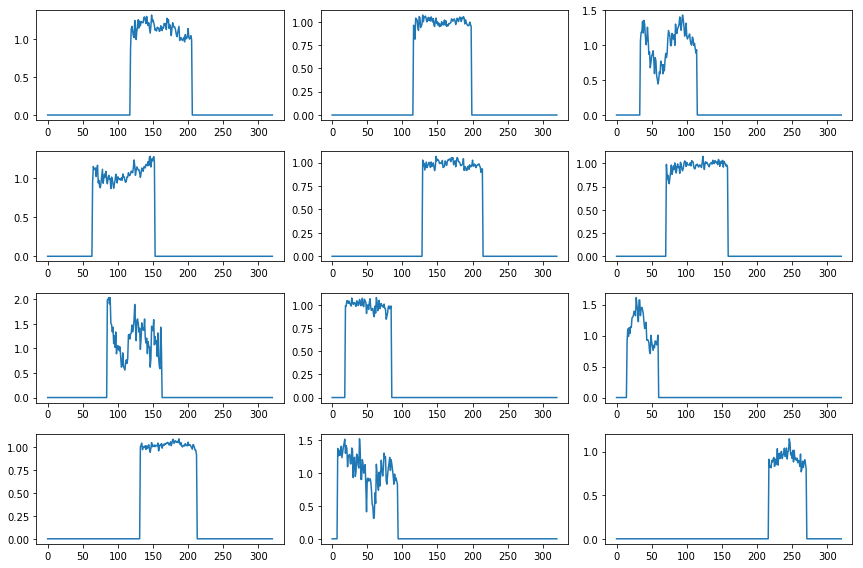

In [5]:
# Choose between synthetic and screening data for demonstration run.
#M = synthetic_data_gen()
M = screening_data_gen()

# Examples of profiles.
_, axes = plt.subplots(ncols=3, nrows=4, figsize=(12, 8))
for i, axis in enumerate(axes.ravel()):
    axis.plot(M[i])
plt.tight_layout()

# Optimal alignment

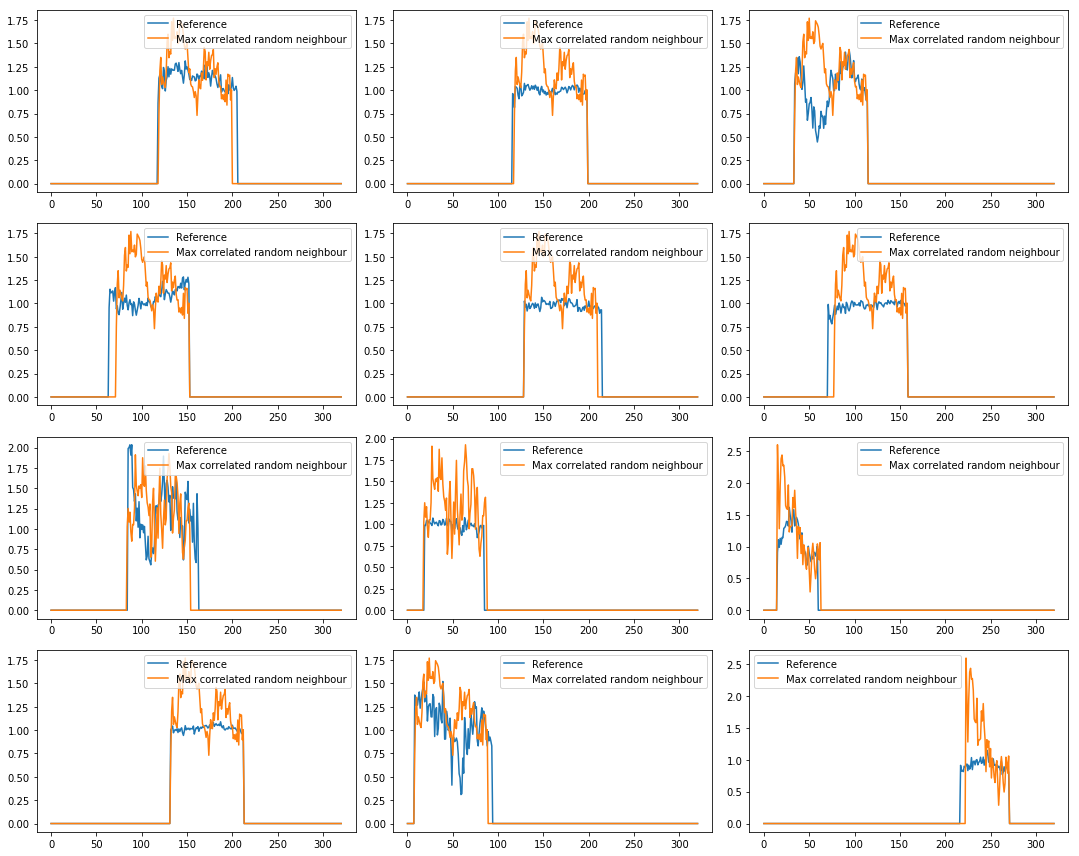

In [6]:
def cross_correlation(i, N_i, M, thresh=0.5):
    
    # TODO: Put checks in helper func.
    if isinstance(N_i, (int, float)):
        N_i = np.array([int(N_i)])
        
    if not isinstance(N_i, np.ndarray):
        N_i = np.array(N_i)
        
    if np.ndim(N_i) < 1:
        N_i = np.expand_dims(N_i, axis=0)
        
    N_i_star, T_i_star, C_i_star = [], [], []
    for j, m_j in enumerate(M[N_i]):
    
        c = signal.correlate(m_j, M[i]) 

        c_max = max(c) / sum(c != 0)
        if c_max > thresh:
                   
            T_i_star.append(np.argmax(c) + 1 - len(m_j))
            C_i_star.append(c_max)
            
            # NOTE: Retain only the neighbours sufficiently correlated.
            N_i_star.append(N_i[j])

    return T_i_star, C_i_star, N_i_star


def align(C, taus):
    
    if not taus:
        raise ValueError("Neighbourhood empty.")
    
    C_aligned = []
    for c, tau in zip(C, taus):
        
        p = np.argmax(c != 0)
        
        if tau > 0:
            k = p - tau
            
        elif tau < 0:
            k = abs(tau) + p

        else:
            k = p
        
        c_shifted = np.zeros_like(c)
        
        if k < 0:

            sliced_c = c[c > 0][abs(k):]   
            c_shifted[:len(sliced_c)] = sliced_c

        else:
            c_shifted[k:sum(c > 0) + k] = c[c > 0]
        
        C_aligned.append(c_shifted)
        
    return np.array(C_aligned)


# Find optimal alignment of two random profiles.
_, axes = plt.subplots(ncols=3, nrows=4, figsize=(15, 12))
for i, axis in enumerate(axes.ravel()):
    
    # Select random neighbours (can also include self in this demosntration).
    np.random.seed(42)
    N_i = np.asarray(np.random.choice(range(M.shape[0]), size=10, replace=False))
    
    # Find optimal alignment of elegible neighbours.
    T_i_star, C_i_star, N_i_star = cross_correlation(i, N_i, M, thresh=0.5) 
    aligned_neighbours = align(M[N_i_star], T_i_star)

    # Display most correlated profiles.
    axis.plot(M[i], label="Reference")
    axis.plot(aligned_neighbours[np.argmax(C_i_star)], label="Max correlated random neighbour")
    axis.legend()
plt.tight_layout()

# Profile synthesis

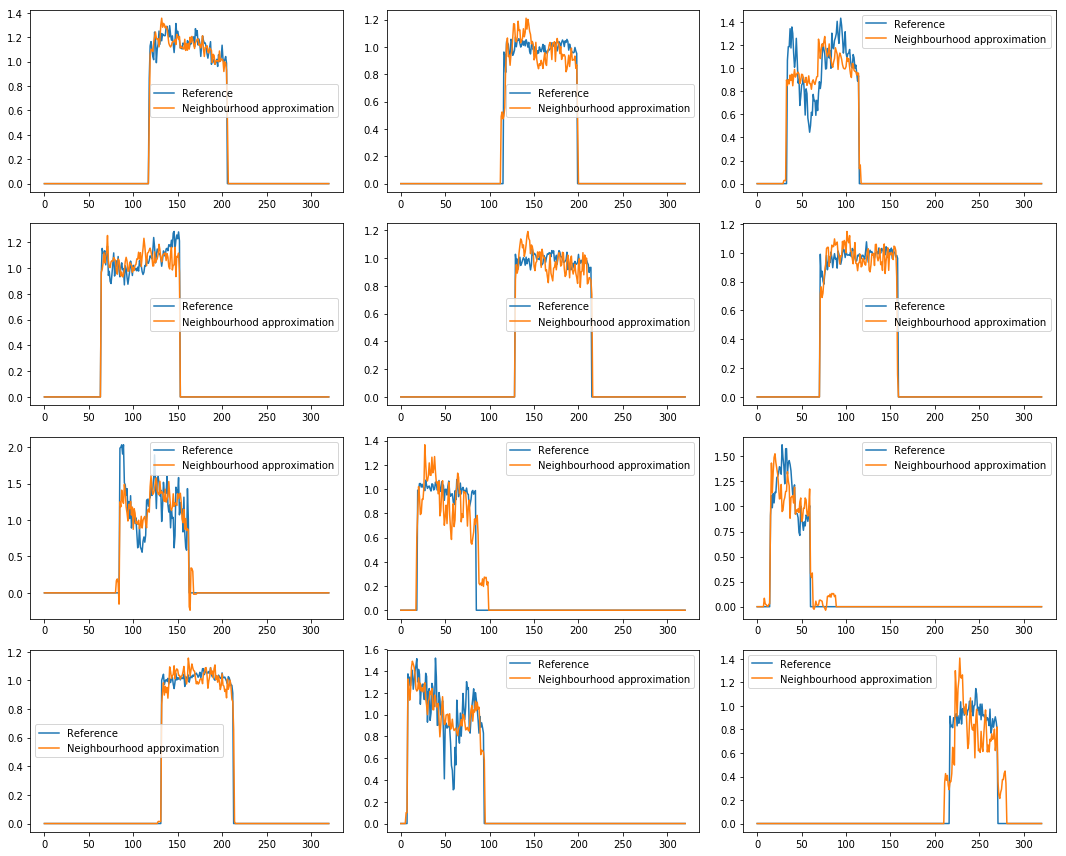

In [7]:
# TODO: Beta should be convex combination.
def synthesize(i, m_i, N_i, alpha=0):
        
    model = Ridge(alpha=alpha, fit_intercept=False)
    model.fit(np.transpose(N_i), m_i)
    
    return np.transpose(N_i) @ model.coef_


# Find use random profiles to approximate a reference profile.
_, axes = plt.subplots(ncols=3, nrows=4, figsize=(15, 12))
for i, axis in enumerate(axes.ravel()):
    
    # Select random neighbours (can also include self in this demosntration).
    np.random.seed(42)
    N_i = np.asarray(np.random.choice(range(M.shape[0]), size=10, replace=False))
    
    # Find optimal alignment of elegible neighbours.
    T_i_star, C_i_star, N_i_star = cross_correlation(i, N_i, M, thresh=0.5) 
    aligned_neighbours = align(M[N_i_star], T_i_star)
    
    # Display most correlated profiles.
    axis.plot(M[i], label="Reference")
    axis.plot(synthesize(i, M[i], aligned_neighbours, alpha=0), label="Neighbourhood approximation")
    axis.legend()
    
plt.tight_layout()

# Update $A$

In [8]:
# NOTE: Here can also sovle som optimization to add global smoothness to A.
def update_adjacency(A, improved, N, C=None):
    """
    Args:
        A: Adjacency matrix in previous iteration.
        improved: Indicate improved loss with current neighbours.
        C (optional): Cross-correlation in node neighbourhoods.
    """
    
    A_new = A.copy().astype(float)

    to_update = np.squeeze(np.where(improved))
    for i in to_update:

        if not N[i]:
            continue

        # Erase previous neighbourhood.
        A_new[i, :] = 0
        A_new[:, i] = 0
        
        # Weighted.
        if C is not None:
            
            A_new[i, N[i]] = C[i]
            A_new[N[i], i] = C[i]

        else:
            
            A_new[i, N[i]] = 1
            A_new[N[i], i] = 1

    # Just in case.
    np.fill_diagonal(A_new, 0)

    # Sanity check.
    assert np.array_equal(A_new, A_new.T)
    
    return A_new


# Demo run.
A = np.array([[0, 1, 1, 1],
              [1, 0, 1, 0],
              [1, 1, 0, 1],
              [1, 0, 1, 0]])

GT = np.array([[0, 0, 1, 1],
               [0, 0, 0, 0],
               [1, 0, 0, 1],
               [1, 0, 1, 0]])

N_star = [[2, 3], [], [0, 3], [0, 2]]

# NOTE: `improved` indicates if this neighbourhood improves on the previous.
A_new = update_adjacency(A, improved=[True, True, True, False], N=N_star)
assert np.array_equal(A_new, GT)

C = [[0.5, 0.5], [], [10, 10], [-9, -9]]
print(update_adjacency(A, improved=[True, True, True, False], N=N_star, C=C))

[[ 0.   0.  10.   0.5]
 [ 0.   0.   0.   0. ]
 [10.   0.   0.  10. ]
 [ 0.5  0.  10.   0. ]]


# Update $M$

In [21]:
"""
def approximate_M(M, A):

    M_star, N_star, C_star = [], [], []
    for i, a in enumerate(A):

        N_i = np.squeeze(np.where(a))
        if np.size(N_i) < 1:
    
            M_star.append(np.zeros_like(M[i]))
            continue
        
        # Align neighbours of i.
        T_i_star, C_i_star, N_i_star = cross_correlation(i, N_i, M, thresh=0) 

        if np.size(N_i_star) < 1:
            M_star.append(np.zeros_like(M[i]))
            continue 
        
        # Approximate m_i using the neighbours of i.
        m_i_hat = synthesize(i, M[i], align(M[N_i_star], T_i_star), alpha=0)
        
        M_star.append(m_i_hat)
        N_star.append(N_i_star)
        C_star.append(C_i_star)
        
    return np.array(M_star), np.array(N_star), np.array(C_star)

    
def smoothing(M, M_star, L, alpha=0.5, beta=0.5):
    # Solves \min_{\hat{M}} | M - \hat{M} |_F^2 + \gamma tr(\hat{M}^\top L \hat{M}).
        
    return np.array(np.linalg.inv(np.eye(M.shape[0]) + beta * L) @ (alpha * M + M_star * (1 - alpha)))


# Random graph.
n = 8
G = nx.erdos_renyi_graph(n=n, p=0.05, seed=42, directed=False)
A = nx.to_numpy_array(G)
L = nx.normalized_laplacian_matrix(G).todense()

# Approximate each m_i using the randomly assigned neighbours.
M_star = approximate_M(M, A)

# Trade-off local and local smoothing.
M_hat = smoothing(M[:n], M_star, L, alpha=0.5, beta=0.4)

_, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 6))
for i, axis in enumerate(axes.ravel()):

    axis.plot(M[i], label="Reference")
    axis.plot(M_star[i], label="Approximation")
    axis.plot(M_hat[i], label="Smoothened", alpha=0.7)
    axis.legend()
    
plt.tight_layout()
"""

'\ndef approximate_M(M, A):\n\n    M_star, N_star, C_star = [], [], []\n    for i, a in enumerate(A):\n\n        N_i = np.squeeze(np.where(a))\n        if np.size(N_i) < 1:\n    \n            M_star.append(np.zeros_like(M[i]))\n            continue\n        \n        # Align neighbours of i.\n        T_i_star, C_i_star, N_i_star = cross_correlation(i, N_i, M, thresh=0) \n\n        if np.size(N_i_star) < 1:\n            M_star.append(np.zeros_like(M[i]))\n            continue \n        \n        # Approximate m_i using the neighbours of i.\n        m_i_hat = synthesize(i, M[i], align(M[N_i_star], T_i_star), alpha=0)\n        \n        M_star.append(m_i_hat)\n        N_star.append(N_i_star)\n        C_star.append(C_i_star)\n        \n    return np.array(M_star), np.array(N_star), np.array(C_star)\n\n    \ndef smoothing(M, M_star, L, alpha=0.5, beta=0.5):\n    # Solves \\min_{\\hat{M}} | M - \\hat{M} |_F^2 + \\gamma tr(\\hat{M}^\top L \\hat{M}).\n        \n    return np.array(np.linalg.in

# Sample new neighbours

In [22]:
# * Try a different adjacency matrix than the previous.
# * Change neighbourhoods in A based on overlap between existing neighbourhoods.
# * Makes the neighbourhoods of the two most similar neighbourhoods identical.


# See also: https://stackoverflow.com/questions/49733244/how-can-i-calculate-neighborhood-overlap-in-weighted-network
def neighbourhood_similarity(N_i, N_j):
    
    return jaccard_score(N_i, N_j)


def sample_candidate_neighbours(A):
    
    A_new = A.copy()
    
    to_update = np.arange(A.shape[0])
    while len(to_update) > 2:

        np.random.seed(42)
        i = np.random.choice(to_update)

        # Neighbourhoods to compare with N_i.
        candidates = np.random.choice(to_update, size=min(len(to_update), 3), replace=False)
        
        # Remove i from update set.
        to_update = np.setdiff1d(to_update, i)

        max_overlap = 0
        j = None
        for num, c in enumerate(candidates):

            score = neighbourhood_similarity(A[i], A[c])
            if score > max_overlap:

                max_overlap = score 
                j = c

        if max_overlap == 1:

            # Connect i and j.
            A_new[i, j] = 1
            A_new[j, i] = 1

        else:

            # Union of both neighbourhoods.
            N_new = np.logical_or(A[i], A[j])

            # Add neighbours from j to i and i to j.
            A_new[i, N_new] = 1
            A_new[N_new, i] = 1

        # Remove j from update set.
        to_update = np.setdiff1d(to_update, j)
        
    return A_new


# Demo run.
n = 5
G = nx.erdos_renyi_graph(n=n, p=0.3, seed=42, directed=False)
A = nx.to_numpy_array(G)
print(A)
print()

A_new = sample_candidate_neighbours(A)
print(A_new)

[[0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0.]
 [1. 0. 1. 0. 1.]
 [1. 0. 0. 1. 0.]]

[[0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0.]
 [1. 0. 1. 1. 1.]
 [1. 0. 0. 1. 1.]]


# Annealing schedules

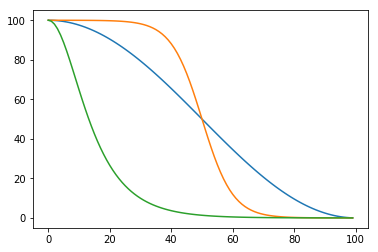

In [37]:
# https://www.chegg.com/homework-help/questions-and-answers/hello-help-please-simulated-annealing-cooling-schedules-figure-1-various-cooling-schedules-q33202578

f1 = lambda T0, x: 0.5 * T0 * (1 + np.cos(x * np.pi / len(x)))
f2 = lambda T0, x: 0.5 * T0 * (1 - np.tanh(10 * x / len(x) - 5))
f3 = lambda T0, x: T0 / np.cosh(10 * x / len(x))
    
x = np.arange(100)
        
plt.figure()
plt.plot(f1(100, x))
plt.plot(f2(100, x))
plt.plot(f3(100, x))

# Acceptance probability

In [26]:
def p_accept(E, E_new, T):
    
    if E_new < E:
        return 1.0
    
    return np.exp(-1.0 * (E_new - E) / T)


# Magnitude of T should be on the order of E, E_new
p_accept(1000, 100, 100), p_accept(1, 10, 1000), p_accept(900, 1000, 1000)

(1.0, 0.9910403787728836, 0.9048374180359595)

# Putting it all together

Our goal is to derive an adjacency matrix $\left \{ A \in \mathcal{A} \mid A = A^\top, A_{i,j} \geq 0 \right \}$ connecting together signal vectors $m \in M$ by trading off local for global smoothness. We measure local smoothness over the neighbourhood $\mathcal{N}(i)$ of node $i$ as $m_i - \hat{m_i}$ where 

$$
    \hat{m}_i = \sum_{j \in \mathcal{N}^*(i)} m_j \beta^*_j, \quad \beta^*  = \min_{\beta, \sum_j \beta_j = 1} \left \| m_i - \sum_{j \in \mathcal{N}^*(i)} m_j \beta_j \right  \|_2^2 + \lambda \left \| \beta \right \|_2^2.
$$

Here, $j \in \mathcal{N}^*(i)$ is a neighbour of node $i$. Each $j$ associate a signal vector $m_j$, which we aligned to $m_i$ by means of cross-correlation $\tau^* = \arg \max_t (m_i \star m_j)(t)$ and the shift operator $S^{\tau^*} m_j = m_j(t - \tau^*)$. Moreover, node $j$ is only included in $\mathcal{N}^*(i)$ if $\max_t (m_i \star m_j)(t) > \epsilon$. The global smoothness we measure using $tr (\hat{M}^\top L \hat{M} )$.

We define the energy over the graph as

$$
    E(A) = \beta \left \| M - \hat{M} \right \|_F^2 + (1 - \beta) tr (\hat{M}^\top L \hat{M} )
$$

and seek to minimize $E(A)$ using an adaptation of simulated annealing (SA). The SA algorithm minimizes a function over a budget of $N$ iterations. For each iteration $n + 1 \leq N$, a candidate adjacency matrix $A_{n+1}$ is selected. With $A_{n+1}$, we compute $E(A_{n + 1})$ and evaluate 
$$
    P(E(A_n), E(A_{n + 1}), T(n)) \geq u
$$
for $u \sim U(0, 1)$. Here $P(\cdot)$ gives the probability of accepting $A_{n+1}$ as the current adjacency matrix and $T(n)$ is the *annealing function* evalauted at step $n$. We currently define $P$ as 

$$
P(E(A_n), E(A_{n + 1}), T(n)) = \begin{cases}
1 & \text{ if } E(A_{n+1}) < E(A_n) \\ 
\exp\left ( - \left ( \frac{E(A_{n+1}) - E(A_n)}{T} \right ) \right ) & \text{ otherwise }
\end{cases}
$$

and use an annealing schedule

$$
    T(n) =  \frac{T_0}{N} \left ( 1 - \tanh\left ( 10 \frac{n}{N} - 5 \right ) \right )
$$

Some alternative annealing schedules are
$$
T(n) = \frac{T_0}{2} \left ( 1 + \cos\left ( \frac{n \pi}{N} \right ) \right ), \quad 
T(n) =  \frac{T_0}{\cosh(10 n / N)}
$$

To generate a new candidate $A_{n+1}$ we randomly select some nodes and measure the overlap between the neighbourhood for each of these nodes and the neighbourhood of each of some other randomly selected nodes. Suppose we select node $i$ and compare its neighbourhood $\mathcal{N}_i$ against the neighbourhood of node $j$. First, we make sure $i \notin \mathcal{N}_j$. Then we measure the similarity between $\mathcal{N}_i$ and $\mathcal{N}_j$ using the Jaccard similarty 

$$
    J = \frac{\mathcal{N}_i \cap  \mathcal{N}_j}{\mathcal{N}_i \cup \mathcal{N}_j}
$$

where $0 \leq J \leq 1$. If $J = 1$ we connct $i$ to $j$. However, if $J < 1 \Rightarrow \mathcal{N}_n(i) \cap  \mathcal{N}_n(j) < \max \left \{ \left | \mathcal{N}_n(i) \right |, \left | \mathcal{N}_n(j) \right | \right \}$ so assign $k \in \mathcal{N}_n(i) \setminus \mathcal{N}_n(j) \rightarrow \mathcal{N}_n(j)$ and assign $p \in \mathcal{N}_n(j) \setminus \mathcal{N}_n(i) \rightarrow \mathcal{N}_n(i)$. Now $\mathcal{N}_{n + 1}(i) \setminus \mathcal{N}_{n + 1}(j) = \emptyset$. This approach resembles collaborative filtering. 

In [27]:
def energy(M, M_hat, A, beta):
    """Evaluate \min_{A} | M - M^* |_F^2 + \gamma tr((M^*)^\top L M^*)."""
    
    L = csgraph.laplacian(A, normed=True)
    
    loss_local = np.linalg.norm(M - M_hat) ** 2
    loss_global = np.trace(M_hat.T @ L @ M_hat)
    
    return beta * loss_local + (1 - beta) * loss_global

In [38]:
def annealing_schedule(T0, x):
    
    return 0.5 * T0 * (1 - np.tanh(10 * x / len(x) - 5))

In [43]:
def init_step(A, M, thresh, alpha, beta):
    
    # NOTE: Approximates M on the updated neighbourhoods in A.
    M_hat, N_star, C_star = approximate_M(A, M, alpha=alpha, thresh=thresh)
    
    # NOTE: Need to handle mix between binary and real-values if A is weighted.
    A_star = update_adjacency(A, improved=np.arange(A.shape[0]), N=N_star, C=None)
    
    return A_star, energy(M, M_hat, A_star, beta)

In [44]:
def run_step(A, M, thresh, loss, alpha, beta):
    
    # NOTE: Approximates M on the updated neighbourhoods in A.
    M_hat, N_star, C_star = approximate_M(A, M, alpha=alpha, thresh=thresh)
    
    loss_new = np.linalg.norm(M - M_hat)
    improved = check_iterable(np.squeeze(np.where(loss_new < loss)))
    
    # NOTE: Need to handle mix between binary and real-values if A is weighted.
    A_star = update_adjacency(A, improved=improved, N=N_star, C=None)

    return A_star, energy(M, M_hat, A_star, beta), loss_new

In [30]:
# NOTE: Will only add more neighbours to a node so can potentially make A very dense.
def update_neighbourhood(max_overlap, A_new, A, i, j):
    
    # Connect i and j.
    if max_overlap == 1:

        A_new[i, j] = 1
        A_new[j, i] = 1

    # Add neighbours from j to i and i to j.
    else:

        # Union of both neighbourhoods.
        N_new = np.logical_or(A[i], A[j])

        A_new[i, N_new] = 1
        A_new[N_new, i] = 1

In [31]:
def update_adjacency(A, improved, N, C=None):
    """Update A after removing neighbours not sufficiently correlated.
    """
    
    A_new = A.copy().astype(float)

    to_update = np.squeeze(np.where(improved))
    for i in to_update:

        if not N[i]:
            continue

        # Erase previous neighbourhood.
        A_new[i, :] = 0
        A_new[:, i] = 0
        
        # Weighted.
        if C is not None:
            
            A_new[i, N[i]] = C[i]
            A_new[N[i], i] = C[i]

        else:
            
            A_new[i, N[i]] = 1
            A_new[N[i], i] = 1

    # Just in case.
    np.fill_diagonal(A_new, 0)

    # Sanity check.
    assert np.array_equal(A_new, A_new.T)
    
    return A_new

In [32]:
def candidate_adjacency(A, m, seed=42):
    """
    Args:
        A: Current adjacency matrix.
        to_update: Update the neighbourhood of these nodes.
        k: Number of other neighbourhoods to compare with.
    """
    
    np.random.seed(seed)
    
    to_update = np.random.choice(range(A.shape[0]), replace=False,
                                 size=min(A.shape[0], m))
    
    A_new = A.copy()    
    for i in to_update:
        
        # Ensure i not in N_j.
        candidates = np.concatenate([np.arange(i), np.arange(i + 1, A.shape[0])])
        candidates = np.random.choice(candidates, replace=False, 
                                      size=min(m, len(candidates)))

        N_i = A[i]
        
        new_hood = None
        max_overlap = 0
        
        for j in candidates:
            
            overlap = neighbourhood_similarity(N_i, A[j])
            if overlap > max_overlap:
                
                new_hood = j
                max_overlap = overlap
        
        # NOTE: Should update matrix in place.
        update_neighbourhood(max_overlap, A_new, A, i, j)
    
    # Just in case.
    np.fill_diagonal(A_new, 0)

    # Sanity check.
    assert np.array_equal(A_new, A_new.T)
                
    return A_new

In [33]:
# See also: https://stackoverflow.com/questions/49733244/how-can-i-calculate-neighborhood-overlap-in-weighted-network
def neighbourhood_similarity(N_i, N_j):
    
    return jaccard_score(N_i != 0, N_j != 0)


def intial_adjacency(n, p, seed):
    
    # Initialize with random adjancey.
    G = nx.erdos_renyi_graph(n=n, p=p, seed=seed, directed=False)
    return nx.to_numpy_array(G)
    
    
def approximate_M(A, M, alpha=0, thresh=0):

    M_star, N_star, C_star = [], [], []
    for i, a in enumerate(A):

        N_i = np.squeeze(np.where(a))
        
        # What if node i does not have any neighbours?
        if np.size(N_i) < 1:
    
            M_star.append(np.zeros_like(M[i]))
            N_star.append([])
            C_star.append([])
        
            continue
        
        # Align neighbourhood of i.
        T_i_star, C_i_star, N_i_star = cross_correlation(i, N_i, M, thresh=thresh) 
        
        # What if node i lost all neighbours?
        if np.size(N_i_star) < 1:
            m_i_hat = np.zeros_like(M[i])
        
        else:
            
            # Approximate m_i using the neighbours of i.
            m_i_hat = synthesize(i, M[i], align(M[N_i_star], T_i_star), alpha=alpha)
        
        M_star.append(m_i_hat)
        N_star.append(N_i_star)
        C_star.append(C_i_star)
        
    return np.array(M_star), np.array(N_star), np.array(C_star)


def check_iterable(N_i):
    """Check the neighbourhood data structure."""
    
    if isinstance(N_i, (int, float)):
        N_i = np.array([int(N_i)])
        
    if not isinstance(N_i, np.ndarray):
        N_i = np.array(N_i)
        
    if np.ndim(N_i) < 1:
        N_i = np.expand_dims(N_i, axis=0)
        
    return N_i


def cross_correlation(i, N_i, M, thresh=0.5):
    
    N_i = check_iterable(N_i)
    
    N_i_star, T_i_star, C_i_star = [], [], []
    for j, m_j in enumerate(M[N_i]):
    
        c = signal.correlate(m_j, M[i]) 

        c_max = max(c) / sum(c != 0)
        if c_max > thresh:
                   
            T_i_star.append(np.argmax(c) + 1 - len(m_j))
            C_i_star.append(c_max)
            
            # NOTE: Retain only the neighbours sufficiently correlated.
            N_i_star.append(N_i[j])

    return T_i_star, C_i_star, N_i_star


def align(C, taus):
    
    if not taus:
        raise ValueError("Neighbourhood empty.")
    
    C_aligned = []
    for c, tau in zip(C, taus):
        
        p = np.argmax(c != 0)
        
        if tau > 0:
            k = p - tau
            
        elif tau < 0:
            k = abs(tau) + p

        else:
            k = p
        
        c_shifted = np.zeros_like(c)
        
        if k < 0:

            sliced_c = c[c > 0][abs(k):]   
            c_shifted[:len(sliced_c)] = sliced_c

        else:
            c_shifted[k:sum(c > 0) + k] = c[c > 0]
        
        C_aligned.append(c_shifted)
        
    return np.array(C_aligned)


# TODO: Beta should be convex combination.
def synthesize(i, m_i, N_i, alpha=0):
        
    #model = Ridge(alpha=alpha, fit_intercept=False)
    #model.fit(np.transpose(N_i), m_i)
    
    #return np.transpose(N_i) @ model.coef_
    
    beta = np.linalg.inv(N_i @ N_i.T) @ N_i @ m_i
    
    return N_i.T @ beta

In [45]:
# NOTE: Code breaks with weighted adjacency.
def main_procedure(A, M, num_epochs, thresh, m=5, alpha=0, beta=0, seed=42):
    
    # Initial adjacency and energy.
    A, E = init_step(A, M=M, thresh=thresh, alpha=alpha, beta=beta)
    
    # Initial loss.
    loss = np.linalg.norm(M, axis=1)

    # Temperature should be at the magnitude of energy levels.
    T = annealing_schedule(T0=E, x=np.arange(num_epochs))
    
    for T_n in T:
        
        # QUESTION: When passing seed to the the function, will 
        # this give a different A_new in each iter even if A is not 
        # updated?
        A_new = candidate_adjacency(A, m=m, seed=seed)

        A_new, E_new, loss_new = run_step(A_new, M=M, thresh=thresh, loss=loss, 
                                          alpha=alpha, beta=beta)
    
        # Move on to next state.
        if p_accept(E, E_new, T_n) >= np.random.random():
            
            A = A_new
            E = E_new
            loss = loss_new
        
    return A


n = 6
A_init = intial_adjacency(n=n, p=0.4, seed=42)
print(A_init)
print()

# Increase m to increase density in A. 
# Increase thresh to decrease density in A. 
main_procedure(A_init, M[:n], num_epochs=10, thresh=0.5, m=2)

[[0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1.]
 [1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]



array([[0., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0.],
       [1., 0., 1., 0., 1., 1.],
       [1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

# Old but gold

In [ ]:
# NOTE: Need to handle mix between binary and real-values if A is weighted.
def _candidate_adjacency(A, to_update, seed=42):
    
    np.random.seed(seed)
    
    A_new = A.copy()
    while len(to_update) > 2:

        i = np.random.choice(to_update)

        # Neighbourhoods to compare with N_i.
        candidates = np.random.choice(to_update, size=min(len(to_update), 3), replace=False)

        # Remove i from update set.
        to_update = np.setdiff1d(to_update, i)
        
        j = None
        max_overlap = 0
        
        # Find max overlapping neighbourhoods.
        for num, c in enumerate(candidates):

            score = neighbourhood_similarity(A[i], A[c])
            if score > max_overlap:

                max_overlap = score 
                j = c

        if max_overlap == 1:

            # Connect i and j.
            A_new[i, j] = 1
            A_new[j, i] = 1

        else:

            # Union of both neighbourhoods.
            N_new = np.logical_or(A[i], A[j])

            # Add neighbours from j to i and i to j.
            A_new[i, N_new] = 1
            A_new[N_new, i] = 1

        # Remove j from update set.
        to_update = np.setdiff1d(to_update, j)
        
    return A_new

In [ ]:
def solve_M_hat(L, M, M_star, beta, gamma):
    """Solves \min_{\hat{M}} | M - \hat{M} |_F^2 + \gamma tr(\hat{M}^\top L \hat{M})."""
    
    return np.array(np.linalg.inv(np.eye(M.shape[0]) + gamma * L) @ (beta * M + M_star * (1 - beta)))


def objective(M, M_hat, M_star, L, beta):
    """Evaluate \min_{\hat{M}} | M - \hat{M} |_F^2 + \gamma tr(\hat{M}^\top L \hat{M})."""
    
    loss_M = beta * np.linalg.norm(M - M_hat) ** 2
    loss_local = (1 - beta) * np.linalg.norm(M_star - M_hat) ** 2
    loss_global = gamma * np.trace(M_hat.T @ L @ M_hat)
    
    return loss_M + loss_local + loss_global